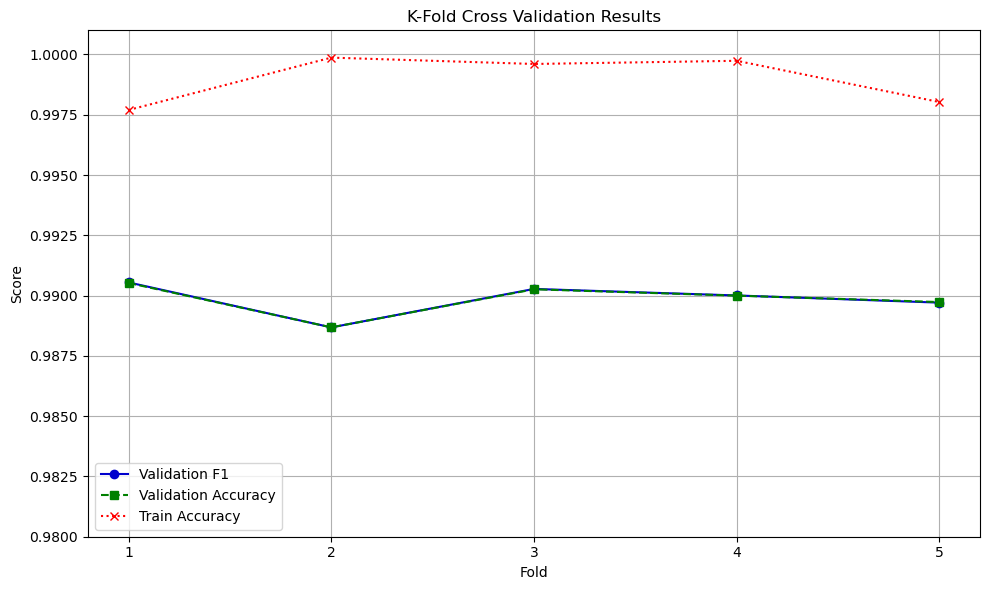

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load saved metrics
df = pd.read_csv("../results/kfold_metrics.csv")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df["fold"], df["val_f1"], marker="o", label="Validation F1", color="mediumblue")
plt.plot(df["fold"], df["val_accuracy"], marker="s", label="Validation Accuracy", color="green", linestyle="--")
plt.plot(df["fold"], df["train_accuracy"], marker="x", label="Train Accuracy", color="red", linestyle=":")

plt.xticks(df["fold"])
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("K-Fold Cross Validation Results")
plt.ylim(0.98, 1.001)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/kfold_performance_plot.png")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
from tqdm import tqdm

In [6]:
# === Load 2025 data ===
df = pd.read_csv("../cleandata/hoax_dataset_2025.csv")
texts = df["cleaned"].tolist()
labels = df["label"].tolist()

In [7]:
# === Load model (adjust path if needed) ===
model_path = "../models/indobert-fold0/checkpoint-3800"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
trainer = Trainer(model=model, tokenizer=tokenizer)

# === Tokenize ===
def tokenize_with_progress(texts, tokenizer, max_length=256):
    encodings = {"input_ids": [], "attention_mask": [], "token_type_ids": []}
    for text in tqdm(texts, desc="Tokenizing 2025 Data"):
        enc = tokenizer(text, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")
        encodings["input_ids"].append(enc["input_ids"].squeeze().tolist())
        encodings["attention_mask"].append(enc["attention_mask"].squeeze().tolist())
        encodings["token_type_ids"].append(enc["token_type_ids"].squeeze().tolist())
    return encodings

encodings = tokenize_with_progress(texts, tokenizer)
dataset = Dataset.from_dict({**encodings, "label": labels})

C:\Users\rzain\AppData\Local\Temp\ipykernel_21084\3790272227.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)
Tokenizing 2025 Data: 100%|██████████| 464/464 [00:00<00:00, 1075.98it/s]


In [18]:
# === Predict ===
predictions = trainer.predict(dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

In [19]:
# === Show Misclassified Samples ===
df_output = df.copy()
df_output["predicted_label"] = y_pred

# Filter rows where prediction is incorrect
misclassified = df_output[df_output["label"] != df_output["predicted_label"]]

# Show first 10 misclassified samples
misclassified.head(10)

,cleaned,label,predicted_label
13,penipuan akun wa disdukcapil minta aktivasi ik...,1,0
21,daftar ptn yang buka jalur mandiri 2025 bebas ...,0,1
25,foto horor serangan israel tewaskan 11 orang d...,0,1
26,foto umat muslim padati masjidil haram jelang ...,0,1
32,salah anggota dpr terima amplop sogokan saat r...,1,0
75,tegang keluar jalur saat mendarat ban pesawat ...,0,1
110,5 berita terpopuler internasional hari ini men...,0,1
156,penampakan desa di swiss hancur terkubur longs...,0,1
193,imigran meksiko dituduh ancam bunuh trump kare...,0,1
201,pengendalian rokok cara menjadikan indonesia m...,0,1


In [ ]:
# === Show Classification Report ===
report_text = classification_report(labels, y_pred, target_names=["Valid", "Hoax"])
print("\n📊 Classification Report (2025 Data):")
print(report_text)



📊 Classification Report (2025 Data):
              precision    recall  f1-score   support

       Valid       0.95      0.92      0.93       203
        Hoax       0.94      0.97      0.95       261

    accuracy                           0.94       464
   macro avg       0.95      0.94      0.94       464
weighted avg       0.94      0.94      0.94       464



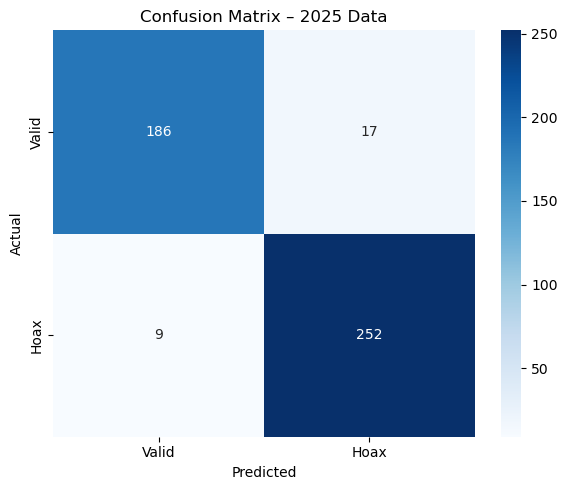

In [ ]:
# === Show Confusion Matrix ===
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Valid", "Hoax"], yticklabels=["Valid", "Hoax"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – 2025 Data")
plt.tight_layout()
plt.show()
plt.close()

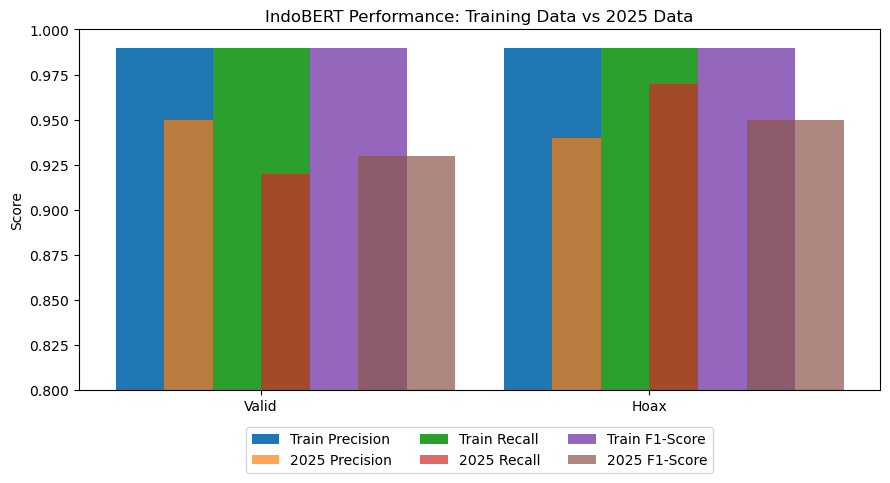

In [29]:
import re
import matplotlib.pyplot as plt
import numpy as np

def parse_report(filepath):
    with open(filepath, "r") as f:
        text = f.read()

    lines = text.strip().split("\n")
    metrics = {}
    for line in lines:
        if line.strip().startswith("Valid") or line.strip().startswith("Hoax"):
            parts = re.split(r"\s{2,}", line.strip())
            label = parts[0].strip()  # Strip spaces around label
            precision, recall, f1 = map(float, parts[1:4])
            metrics[label] = [precision, recall, f1]
    return metrics

# === Load reports ===
metrics_train = parse_report("../results/classification_report_fold1.txt")
metrics_2025 = parse_report("../results/classification_report_2025.txt")

# === Plot ===
labels = ["Valid", "Hoax"]
metric_names = ["Precision", "Recall", "F1-Score"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(9, 5))

for i, metric in enumerate(metric_names):
    scores_train = [metrics_train[label][i] for label in labels]
    scores_2025 = [metrics_2025[label][i] for label in labels]
    offset = (i - 1) * width
    ax.bar(x + offset, scores_train, width, label=f"Train {metric}")
    ax.bar(x + offset + width/2, scores_2025, width, label=f"2025 {metric}", alpha=0.7)

ax.set_ylabel("Score")
ax.set_ylim(0.8, 1.0)
ax.set_title("IndoBERT Performance: Training Data vs 2025 Data")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.25))
plt.tight_layout()
plt.show()
